In [126]:
import gzip
import json
import jsonlines
import os
from tqdm.notebook import tqdm
import time
from collections import defaultdict
import google.generativeai as genai
import pandas as pd
from dotenv import load_dotenv
load_dotenv()

True

In [127]:
key = os.getenv('gemini')

In [128]:
genai.configure(api_key=key)


# Summary Using Gemini

In [117]:
def call_gemini_api(input_text):
    model = genai.GenerativeModel('models/gemini-1.0-pro')
    response = model.generate_content(input_text.strip(), safety_settings={'HARASSMENT':'block_none',
                                                     'HATE_SPEECH': 'block_none',
                                                     'HARM_CATEGORY_DANGEROUS_CONTENT': 'block_none',
                                                     'HARM_CATEGORY_SEXUALLY_EXPLICIT': 'block_none'})
    try:
        return response.text
    except Exception as e:
        # print(response.prompt_feedback)
        return "UNSAFE"

In [100]:
instruction = """Give a concise summary for the below description of the product in the form {"summary": ...}.\n\nProduct Info:\n"""

In [101]:
def parse(path):
  g = gzip.open(path, 'r')
  for l in g:
    yield json.loads(l)

# Fetch Products for desired categories

In [102]:
def get_info_from_sample(sample:dict):
    description = sample.get("description", None)
    if isinstance(description, list):
        description = " ".join(description)
        
    features = sample.get("feature", None)
    if isinstance(features, list):
        features = "\n- " + "\n- ".join(features)
    
    if description and features:
        return f"""Description:\n{description}\nFeatures:{features}"""
    elif description:
        return description
    elif features:
        return features
    else:
        return None

In [107]:
def get_labelled_data(input_file_path, out_dir, skiplines=0, filename=None):
    inp_file_name = input_file_path.split("/")[-1].strip()
    with jsonlines.open(os.path.join(out_dir, f'{inp_file_name.split(".")[0]}.jsonl'), mode="a") as out_file:
        print(f"Processing file - {input_file_path}")
        ct = 0
        pred_ct = 0
        for sample in parse(input_file_path):
            ct+=1
            if filename and filename==inp_file_name and ct<skiplines:
                continue            

            info = get_info_from_sample(sample)
            if info and len(info.split())>50:
                print(sample)
                try:
                    generated_text = call_gemini_api(instruction+info)
                    print(generated_text)
                    if generated_text!="UNSAFE": out_file.write({"product_info": info, "summary": json.loads(generated_text.strip())["summary"]})
                    pred_ct+=1
                    # generated_text=""
                except Exception as e:
                    # print(e)
                    # if generated_text: print(generated_text)
                    if "deadline" in str(e).lower(): 
                        print("resetting the limit")
                        time.sleep(60)
                break
        print(ct)
            # break
    return pred_ct

## Categories

In [2]:
cats_desired = ['Men Clothing', 'Women Clothing', 'Boys Clothing','Girls Clothing',
'Men Shoes', 'Women Shoes', 'Boys Shoes','Girls Shoes',
'Men Watches', 'Women Watches', 'Boys Watches','Girls Watches']

In [3]:
def fetch_category(sample):
    return sample.get('category', None)
def fetch_req_fields(sample):
    asin = sample.get('asin', None)
    fs = sample.get('feature', None)
    fea=""
    if fs:
        for i in fs:
            fea+=i+"\n"
    ds = sample.get('description', None)
    desc=""
    if ds:
        for i in ds:
            desc+=i+"\n"
    title = sample.get('title', None)

    return {
     "title": title,
     "features": fea,
     "description": desc,
     "asin":asin,
     "imageurl": sample.get('imageURL', None),
     "imageURLHighRes": sample.get('imageURLHighRes', None)
    }



In [132]:

def fetch_cat(input_file_path):
    sub_cats = defaultdict(int)
    output = []
    for sample in parse(input_file_path):
        info = fetch_category(sample)
        if len(info)>=3:
            cat = info[1]+ " "+ info[2]
            if cat in cats_desired and sub_cats[cat]<150:
                dic=fetch_req_fields(sample)
                dic["category"] = cat
                if dic['features'] != "" and dic['description'] != "" and dic['imageurl']:
                    sub_cats[cat]+=1
                    output.append(dic) 
                        # info = get_info_from_sample(sample)
                        # if info and len(info.split())>50:
                        #     try:
                        #         generated_text = call_gemini_api(instruction+info)
                                
                        #         if generated_text!="UNSAFE": 
                        #             dic["summary"] = json.loads(generated_text.strip())["summary"]
                        #             sub_cats[cat]+=1
                        #             print(sub_cats[cat], cat)
                        #             output.append(dic) 
                        #     except Exception as e:
                        #         print(e)
                        #         # if generated_text: print(generated_text)
                        #         if "deadline" in str(e).lower(): 
                        #             print("resetting the limit")
                        #             time.sleep(60)
                      
                 
    return output, sub_cats

In [133]:
output, sub_cats= fetch_cat("train/meta_Clothing_Shoes_and_Jewelry.json.gz")

Processing file - train/meta_Clothing_Shoes_and_Jewelry.json.gz


In [134]:
dataset = pd.DataFrame(output)
dataset.to_csv("products.csv", index=False)

In [135]:
# dataset[~dataset['imageurl'].isna()]['imageurl']
# dataset[dataset['imageurl'].isna()].shape

(0, 7)

# Fetch Reviews

In [ ]:
def fetch_asin(sample):
    return sample.get('asin', None)
def fetch_req_fields(sample):
    asin = sample.get('asin', None)
    return {
     "reviewText": sample.get('reviewText', None) ,
     "summary": sample.get('summary', None),
     "asin":asin,
    }
cats_desired = dataset['asin'].to_list()


In [137]:
from collections import defaultdict
def fetch_reviews(input_file_path):
    sub_cats = defaultdict(int)
    output = []
    print(f"Processing file - {input_file_path}")
    for sample in parse(input_file_path):
        info = fetch_asin(sample)
        if info in cats_desired and sub_cats[info]<10:
                dic=fetch_req_fields(sample)
                    # dic["category"] = cat
                if dic['reviewText'] != "" and dic['summary'] != "":
                    sub_cats[info]+=1
                    output.append(dic) 
                        # info = get_info_from_sample(sample)
                        # if info and len(info.split())>50:
                        #     try:
                        #         generated_text = call_gemini_api(instruction+info)
                                
                        #         if generated_text!="UNSAFE": 
                        #             dic["summary"] = json.loads(generated_text.strip())["summary"]
                        #             sub_cats[cat]+=1
                        #             print(sub_cats[cat], cat)
                        #             output.append(dic) 
                        #     except Exception as e:
                        #         print(e)
                        #         # if generated_text: print(generated_text)
                        #         if "deadline" in str(e).lower(): 
                        #             print("resetting the limit")
                        #             time.sleep(60)
                      
                 
    return output, sub_cats

In [138]:
output, sub_cats= fetch_reviews("train/Clothing_Shoes_and_Jewelry.json.gz")

Processing file - train/Clothing_Shoes_and_Jewelry.json.gz


In [139]:
dataset = pd.DataFrame(output)
dataset.to_csv("reviews.csv", index=False)

(9291, 3)

# EDA

In [8]:
products = pd.read_csv("products.csv")
reviews = pd.read_csv("reviews.csv")

### Number of products

In [10]:
products.shape


(1800, 7)

### Number of products by category

In [36]:
products['category'].nunique()

12

In [13]:
products['category'].value_counts()

Women Clothing    150
Men Clothing      150
Women Watches     150
Men Watches       150
Women Shoes       150
Boys Clothing     150
Men Shoes         150
Girls Shoes       150
Boys Shoes        150
Girls Clothing    150
Girls Watches     150
Boys Watches      150
Name: category, dtype: int64

In [14]:
products.columns

Index(['title', 'features', 'description', 'asin', 'imageurl',
       'imageURLHighRes', 'category'],
      dtype='object')

### Sample Features and description

In [33]:
print(products.iloc[21].features)

cotton blended
Has a fashionable flap over Pocket on the right thigh
Soft, comfortable and machine washable
Mid rise waist
Great for yoga, running, gym fitness workout, casual and fashion occasions
Shipping Information:
                    
View shipping rates and policies



In [34]:
print(products.iloc[21].description)

Y-BIN Women's Leggings Fitted Capris Gym Workout Running Tights Pants A light yoga stretch at home? The fabric is our awesome peach performance fabric. Super soft and a great mid-weight legging.



### Sample Summary

In [ ]:
summary = pd.read_csv('summary_sheet.csv')

In [35]:
print(summary[summary['asin'] == products.iloc[21].asin].iloc[0].summary)

Y-BIN Women's Leggings are soft, cotton-blended tights designed for workouts, yoga, and casual wear. Notable features include a fashionable thigh pocket, mid-rise waist, machine washability, and a comfortable design.


### View Sample High res images

In [39]:
products.iloc[21].imageURLHighRes

"['https://images-na.ssl-images-amazon.com/images/I/41568f4cT9L.jpg', 'https://images-na.ssl-images-amazon.com/images/I/512KEVlARpL.jpg', 'https://images-na.ssl-images-amazon.com/images/I/41JVN%2BCoRGL.jpg']"

In [44]:
import ast
products.iloc[21].imageURLHighRes

"['https://images-na.ssl-images-amazon.com/images/I/41568f4cT9L.jpg', 'https://images-na.ssl-images-amazon.com/images/I/512KEVlARpL.jpg', 'https://images-na.ssl-images-amazon.com/images/I/41JVN%2BCoRGL.jpg']"

In [45]:
array = ast.literal_eval(products.iloc[21].imageURLHighRes)
array[0]

'https://images-na.ssl-images-amazon.com/images/I/41568f4cT9L.jpg'

### Resize Image

In [69]:
import requests
# from IPython.display import display, Image
from PIL import Image
from io import BytesIO

def resize_image_from_url(url, width, height):
    # Download the image from the URL
    response = requests.get(url)
    image = Image.open(BytesIO(response.content))

    # Resize the image
    resized_image = image.resize((width, height))

    return resized_image

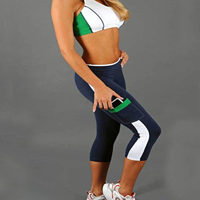

In [71]:
resize_image_from_url(array[0], 200,200)

## Zero-Shot Image Classification using GPT-4 Turbo

In [75]:
from openai import OpenAI

client = OpenAI(api_key=os.getenv('openai'))

response = client.chat.completions.create(
  model="gpt-4-turbo",
  messages=[
    {
      "role": "user",
      "content": [
        {"type": "text", "text": """"
         classify image to following categories and give top 3 close matches from high to low among them:
        
        'Men Clothing', 'Women Clothing', 'Boys Clothing','Girls Clothing',
        'Men Shoes', 'Women Shoes', 'Boys Shoes','Girls Shoes',
        'Men Watches', 'Women Watches', 'Boys Watches','Girls Watches'
         
         Give response in below format:
         {prediction1_category}
         {prediction2_category}
         {prediction3_category}
         """},
        {
          "type": "image_url",
          "image_url": {
            "url": "https://images-na.ssl-images-amazon.com/images/I/41568f4cT9L.jpg",
          },
        },
      ],
    }
  ],
  max_tokens=300,
)



Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='Women Clothing\nGirls Clothing\nWomen Shoes', role='assistant', function_call=None, tool_calls=None))


In [76]:
print(response.choices[0].message.content)

Women Clothing
Girls Clothing
Women Shoes


In [80]:
# ! pip3 install --upgrade pip
# ! pip3 install -q mediapipe



In [83]:
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

In [92]:
BaseOptions = mp.tasks.BaseOptions
model_asset_path='mobilenet_v3_small_075_224_embedder.tflite'

ImageEmbedder = mp.tasks.vision.ImageEmbedder
ImageEmbedderOptions = mp.tasks.vision.ImageEmbedderOptions
VisionRunningMode = mp.tasks.vision.RunningMode

options = ImageEmbedderOptions(
    base_options=BaseOptions(model_asset_path=model_asset_path),
    quantize=True,
    running_mode=VisionRunningMode.IMAGE)


In [89]:
def download_image(url, save_path):
    # Send a GET request to the URL
    response = requests.get(url)
    
    # Check if the request was successful (status code 200)
    if response.status_code == 200:
        # Open the file in binary write mode and write the content
        with open(save_path, 'wb') as f:
            f.write(response.content)
        print("Image downloaded successfully.")
    else:
        print("Failed to download image. Status code:", response.status_code)

download_image("https://images-na.ssl-images-amazon.com/images/I/41568f4cT9L.jpg", "img.jpg")

Image downloaded successfully.


In [98]:
mp_image = mp.Image.create_from_file('img.jpg')
with ImageEmbedder.create_from_options(options) as embedder:
    embedding_result = embedder.embed(mp_image)
    print(embedding_result.embeddings[0].embedding.shape)

(1024,)


I0000 00:00:1712885024.847783 15954842 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  


# Reviews of Products

In [99]:
reviews = pd.read_csv('reviews.csv')

In [102]:
reviews['asin'].value_counts().describe()

count    1670.000000
mean        5.563473
std         3.908999
min         1.000000
25%         1.000000
50%         5.000000
75%        10.000000
max        10.000000
Name: asin, dtype: float64

### We had atleast a review for all the products.

### Summarising Reviews

In [112]:
instruction = """Give a concise summary for the below reviews given by users for the product in the form {"summary": ...}.\n\nReviews:\n"""

In [114]:
def generate_reviews_query(pid):
    reviews_spotlight = reviews[reviews['asin'] == pid]
    text=""
    for _,review in reviews_spotlight.iterrows():
        text+="Heading:\n"
        text+=review['summary']
        text+="Review\n"+review['reviewText']
        text+="\n"
    return text
review_query = generate_reviews_query('5120053475')

In [119]:
summary = call_gemini_api(instruction+review_query)

In [121]:
print(json.loads(summary)['summary'])

These high-quality tights from Veneziana are comfortable, durable, and true to size. The semi-sheer opaque black material provides coverage while allowing skin to show through, and the reinforced waistband offers control. The tights come in three colors (black, cappuccino, and natural) and are available in a range of sizes. Overall, users are very satisfied with these tights and recommend them for everyday wear or special occasions.


### Reference
https://developers.google.com/mediapipe/solutions/vision/image_embedder/python